In [19]:

import json
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_jsonl(file_path: str) -> list[list[dict]]:
    """
    Load and parse a file where each line is a JSON-encoded string representing
    a participant's response data across trials.

    Args:
        file_path: Path to the file containing the data.

    Returns:
        participants_data: Inner lists contain recorded entries for a participant and trial.
    """
    participants_data = []
    with open(file_path, "r") as file:
        for line in file:
            try:
                participant_data = json.loads(line.strip())
                participants_data.append(participant_data)
            except json.JSONDecodeError as e:
                print(f"Error parsing line: {e}")
    return participants_data


def retrieve_conditions(participants_data: list[list[dict]]) -> list[str]:
    """
    Retrieve the condition of each participant from the data.

    Args:
        participants_data: List of lists of dictionaries, where each inner list contains recorded entries for a participant and trial.

    Returns:
        conditions: Contains the condition of each participant.
    """
    conditions = []
    for participant_data in participants_data:
        condition = [
            "Competitive" if (entry["ranked_order"][-1]["team"] == "Opposing Team") else "Casual"
            for entry in participant_data
            if entry.get("trial_type") == "two-team-sortable-rank"
        ]
        conditions.append(condition[0])
    return conditions


def retrieve_subj_demographics(participants_data: list[list[dict]]) -> list[tuple]:
    """
    Returns the self-reported demographics of each participant.

    Args:
        participants_data: List of lists of dictionaries, where each inner list contains recorded entries for a participant and trial.
    """

    full_demographics = []
    for participant_data in participants_data:
        demographics = [
            (
                entry["response"]["race"],
                entry["response"]["gender"],
                int(entry["response"]["age"]),
                entry["response"]["college"],
            )
            for entry in participant_data
            if type(entry.get("response")) is dict
            and entry["response"].get("race") is not None
        ]
        full_demographics.append(demographics[0])
    return full_demographics


def retrieve_deception(participants_data: list[list[dict]]) -> list[str]:
    final_rankings = []
    for participant_data in participants_data:
        final_ranking = [
            entry["response"]["deception"]
            for entry in participant_data
            if type(entry.get("response")) is dict
            and entry["response"].get("deception") is not None
        ]
        final_rankings.append(final_ranking[0])
    return final_rankings


def retrieve_confidence(participants_data: list[list[dict]]) -> list[int]:
    """
    Retrieve participant self rating of their competitive confidence.

    Args:
        participants_data: List of lists of dictionaries, where each inner list contains recorded entries for a participant and trial.

    Returns:
        confidence: Inner lists self-rating for each participant
    """
    final_rankings = []
    for participant_data in participants_data:
        final_ranking = [
            int(entry["response"])
            for entry in participant_data
            if entry.get("stimulus")
            == "<h2>Rating</h2><p>On a scale from 1–10, how typically successful are you in competitive environments?</p>"
        ]
        final_rankings.append(final_ranking)
    return final_rankings


def retrieve_final_ranking(participants_data: list[list[dict]]) -> list[list[str]]:
    """
    Retrieve the final ranking of items from the data.

    Args:
        participants_data: List of lists of dictionaries, where each inner list contains recorded entries for a participant and trial.

    Returns:
        final_rankings: Inner lists contain the final ranking of items for a participant.
    """
    final_rankings = []
    for participant_data in participants_data:
        final_ranking = [
            entry["ranked_order"]
            for entry in participant_data
            if entry.get("trial_type") == "two-team-sortable-rank"
        ]
        final_rankings.append(final_ranking)
    return final_rankings


def generate_subject_ids(participants_data: list[list[dict]]) -> list[int]:
    """
    Selects unique subject id from item-presentation trials across all participants.

    Args:
        participants_data: List of lists of dictionaries, where each inner list contains recorded entries for a participant and trial.

    Returns:
        Contains subject id for a participant and trial combination.
    """
    subject_ids = []
    for subject_id, participant_data in enumerate(participants_data):
        subject_ids.extend(
            subject_id
            for entry in participant_data
            if entry.get("trial_type") == "item-presentation"
        )
    return subject_ids


def extract_race_gender_age(url):
    # Extract the final part of the URL (filename without extension)
    filename = url.split("/")[-1].split(".")[0].lower()
    return filename.split("_")[2:]


def compare_race(raceA: str, raceB: str) -> bool:
    """
    "Asian/Pacific Islander" should match with "Asian-Pacific Islander"
    "Black" should match with "African-American"
    "White" should match with "White"
    "Latino" should match with "Latinx"
    Otherwise no match
    """
    codes = {
        "South Asian": 0,
        "south-asian": 0,
        "East/Southeast Asian": 1,
        "east-asian": 1,
        "Black": 2,
        "black": 2,
        "White": 3,
        "white": 3,
        "Hispanic/Latine/Latinx": 4,
        "latino": 4,
        "Indigenous": 5,
        "Multiracial": 6,
        "Other": 7,
    }
    if codes.get(raceA, np.nan) == codes.get(raceB, np.nan):
        return True
    return False

def convert_race(race: str) -> str:
    races = ["South Asian", "East/Southeast Asian", "Black", "White", "Latino", "Indigenous", "Multiracial", "Other"]
    codes = {
        "South Asian": 0,
        "south-asian": 0,
        "East/Southeast Asian": 1,
        "east-asian": 1,
        "Black": 2,
        "black": 2,
        "White": 3,
        "white": 3,
        "Hispanic/Latine/Latinx": 4,
        "latino": 4,
        "Indigenous": 5,
        "Multiracial": 6,
        "Other": 7,
    }
    return races[codes.get(race)]

def convert_age(age_int: int) -> str|float:
    """
    Convert age_int into age_str based on the following rules:
        - If age_int is <= 24, return "18-24"
        - If age_int is between 25 and 31 (inclusive), return "25-31"
        - If age_int is between 32 and 38 (inclusive), return "32-38"
        - If age_int is above 39 and 45 (inclusive), return "39-45"
        - If age_int is above 45, return "45+"
    """
    if age_int <= 24:
        return "18-24"
    elif age_int >= 25 and age_int <= 31:
        return "25-31"
    elif age_int >= 32 and age_int <= 38:
        return "32-38"
    elif age_int >= 39 and age_int <= 45:
        return "39-45"
    elif age_int > 45:
        return "45+"
    return np.nan

def convert_gender(gender: str) -> str:
    genders = ["Man", "Woman", "Non-binary", "Other"]
    codes = {
        "Man": 0,
        "male": 0,
        "man": 0,
        "Woman": 1,
        "woman": 1,
        "female": 1,
        "Non-binary": 2,
        "Other": 3,
    }
    return genders[codes.get(gender)]

In [20]:

jatos_data_path = "experiments/sortablerank/Team_Building_04_11_2024.jsonl"

data = load_jsonl(jatos_data_path)
final_rankings = retrieve_final_ranking(data)
conditions = retrieve_conditions(data)
subject_demographics = retrieve_subj_demographics(data)
subject_selfratings = retrieve_confidence(data)
subject_deceptions = retrieve_deception(data)

# analyses used: subject age, gender, race,
# dcharacter race, age, gender
# generated "shared_features" column
# output position. "chosen" extracted from output positions

merged = {
    "subject": [],  # ✅
    "output": [],  # ✅
    "chosen": [],  # ✅
    "condition": [],  # ✅
    "subject_race": [],  # ✅
    "subject_age": [],  # ✅
    "subject_gender": [],  # ✅
    "character_race": [],  # ✅
    "character_age": [],  # ✅
    "character_gender": [],  # ✅
    "subj_college": [],  # ✅
    "self_ability": [],  # ✅
    "awareness": [],  # ✅
    "shared_features": [],  # ✅
}
for i in range(len(data)):
    subject_id = i + 1
    condition = conditions[i]
    subject_rankings = final_rankings[i][0]
    subject_selfrating = subject_selfratings[i][0]
    subject_deception = subject_deceptions[i]
    subject_race, subject_gender, subject_age, subject_college = subject_demographics[i]

    output = 0
    for character in subject_rankings:
        character_demographics = extract_race_gender_age(character["label"])
        if not character_demographics:
            continue
        character_race, character_gender, character_age = character_demographics
        output += 1
        chosen = int(character["team"] == "Your Team")
        
        shared_features = 0
        shared_features += compare_race(subject_race, character_race)
        shared_features += convert_age(subject_age) == convert_age(int(character_age))
        shared_features += convert_gender(subject_gender) == convert_gender(character_gender)

        merged["subject"].append(subject_id)
        merged["output"].append(output)
        merged["chosen"].append(chosen)
        merged["condition"].append(condition)
        merged["subject_race"].append(convert_race(subject_race))
        merged["subject_age"].append(convert_age(subject_age))
        merged["subject_gender"].append(convert_gender(subject_gender))
        merged["character_race"].append(convert_race(character_race))
        merged["character_gender"].append(convert_gender(character_gender))
        merged["character_age"].append(convert_age(int(character_age)))
        merged["subj_college"].append(subject_college)
        merged["self_ability"].append(subject_selfrating)
        merged["awareness"].append(subject_deception)
        merged["shared_features"].append(shared_features)

data = pd.DataFrame(merged)
data.head()

,subject,output,chosen,condition,subject_race,subject_age,subject_gender,character_race,character_age,character_gender,subj_college,self_ability,awareness,shared_features
0,1,1,1,Competitive,South Asian,18-24,Man,East/Southeast Asian,18-24,Man,yes,8,no,2
1,1,2,1,Competitive,South Asian,18-24,Man,Black,18-24,Man,yes,8,no,2
2,1,3,1,Competitive,South Asian,18-24,Man,White,39-45,Man,yes,8,no,1
3,1,4,1,Competitive,South Asian,18-24,Man,South Asian,45+,Woman,yes,8,no,1
4,1,5,0,Competitive,South Asian,18-24,Man,White,25-31,Man,yes,8,no,1


In [3]:

data.value_counts(['subject_age'])/16

subject_age
32-38          14.6250
18-24           4.5000
25-31           1.6875
45+             1.6875
39-45           0.5625
Name: count, dtype: float64

In [4]:

data.value_counts(['subject_gender'])/16

subject_gender
Man               18.0000
Woman              5.0625
Name: count, dtype: float64

In [5]:

data.value_counts(['subject_race'])/16

subject_race        
White                   16.8750
South Asian              2.8125
East/Southeast Asian     1.6875
Black                    1.1250
Latino                   0.5625
Name: count, dtype: float64

In [6]:

pd.pivot_table(data, index='shared_features', values='chosen', aggfunc='mean')

,chosen
shared_features,
0,0.372549
1,0.457895
2,0.485714
3,0.714286


In [7]:

pd.pivot_table(data, index='shared_features', columns='condition', values='chosen', aggfunc='mean')

condition,Casual,Competitive
shared_features,,
0,0.450000,0.322581
1,0.433735,0.476636
2,0.428571,0.542857
3,0.750000,0.666667


In [8]:

pd.pivot_table(data, index='output', values='shared_features', aggfunc='mean')

,shared_features
output,
1,0.951220
2,1.121951
3,1.170732
4,0.902439
5,0.926829
6,1.024390
7,0.707317
8,1.048780
9,0.707317


In [9]:

pd.pivot_table(data, index='subject_race', columns='character_race', values='chosen', aggfunc='mean')

character_race,Black,East/Southeast Asian,Latino,South Asian,White
subject_race,,,,,
Black,0.000000,0.000000,1.000000,0.600000,0.333333
East/Southeast Asian,0.375000,1.000000,0.000000,0.800000,0.333333
Latino,1.000000,0.000000,0.500000,1.000000,0.000000
South Asian,0.500000,0.636364,0.272727,0.600000,0.250000
White,0.346154,0.365385,0.407407,0.509434,0.576271


In [10]:
pd.pivot_table(data, index='subject_gender', columns='character_gender', values='chosen', aggfunc='mean')

character_gender,Man,Woman
subject_gender,,
Man,0.431655,0.456376
Woman,0.428571,0.461538


In [11]:

pd.pivot_table(data, index='subject_age', columns='character_age', values='chosen', aggfunc='mean')

character_age,18-24,25-31,32-38,39-45,45+
subject_age,,,,,
18-24,0.590909,0.529412,0.428571,0.166667,0.285714
25-31,0.750000,0.250000,0.555556,0.333333,NaN
32-38,0.458333,0.500000,0.500000,0.360000,0.250000
39-45,0.333333,0.666667,0.333333,NaN,NaN
45+,0.333333,0.400000,0.444444,0.750000,NaN


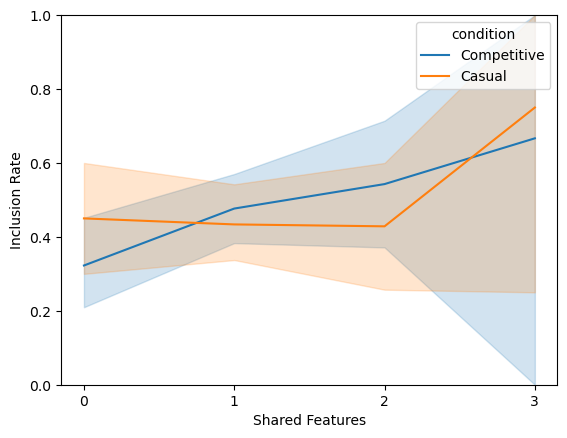

In [12]:

g = sns.lineplot(
    data=data, 
    x='shared_features', y='chosen', hue='condition')
g.set_xlabel('Shared Features')
g.set_xticks([0, 1, 2, 3])
g.set_ylim(0, 1)
g.set_ylabel('Inclusion Rate');

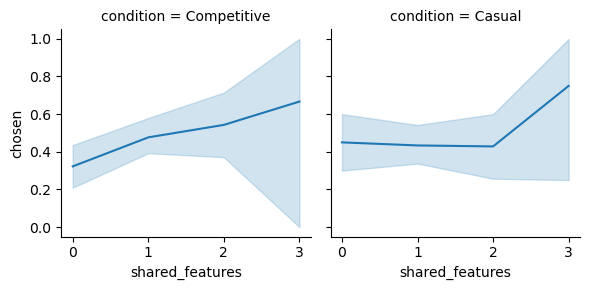

In [13]:

g = sns.FacetGrid(data, col='condition', sharey=True)
g.map(sns.lineplot, 'shared_features', 'chosen')

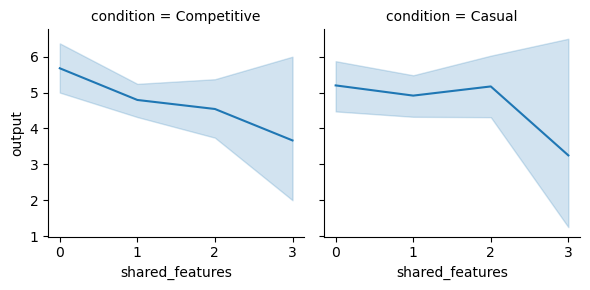

In [14]:

g = sns.FacetGrid(data, col='condition', sharey=True)
g.map(sns.lineplot, 'shared_features', 'output')

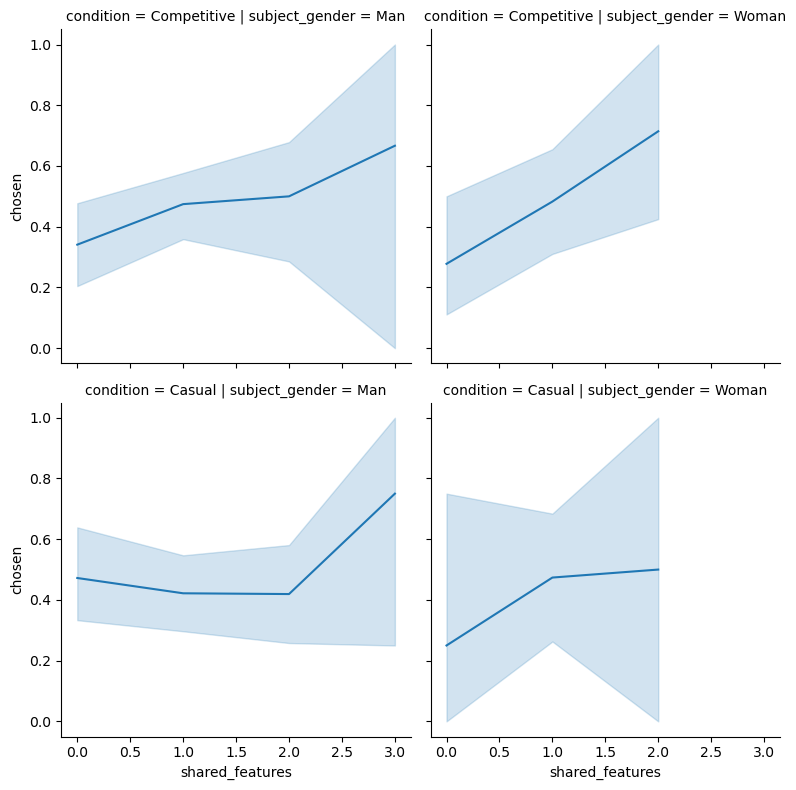

In [15]:

g = sns.FacetGrid(data, col='subject_gender', row='condition', sharey=True, height=4)
g.map(sns.lineplot, 'shared_features', 'chosen')

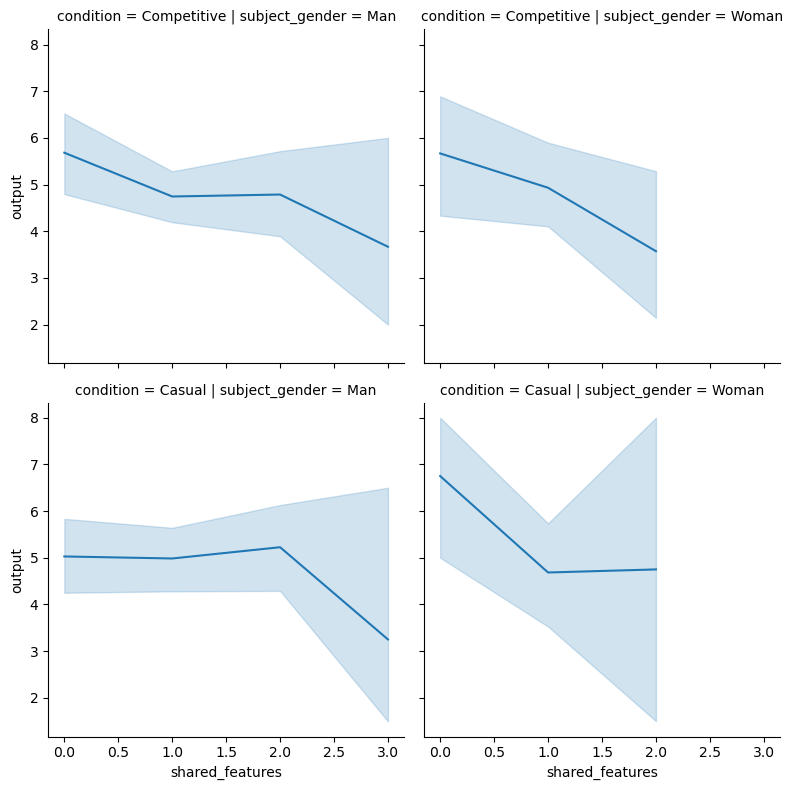

In [16]:

g = sns.FacetGrid(data, col='subject_gender', row='condition', sharey=True, height=4)
g.map(sns.lineplot, 'shared_features', 'output')

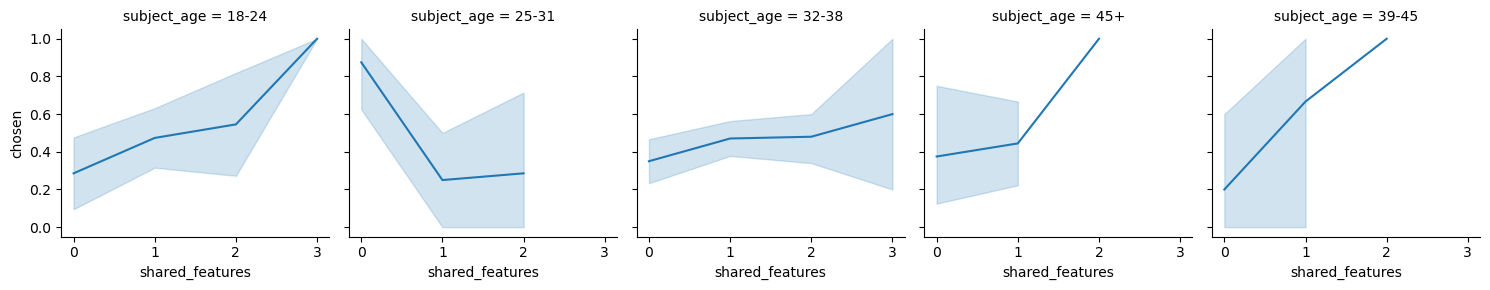

In [17]:

g = sns.FacetGrid(data, col='subject_age', sharey=True)
g.map(sns.lineplot, 'shared_features', 'chosen')

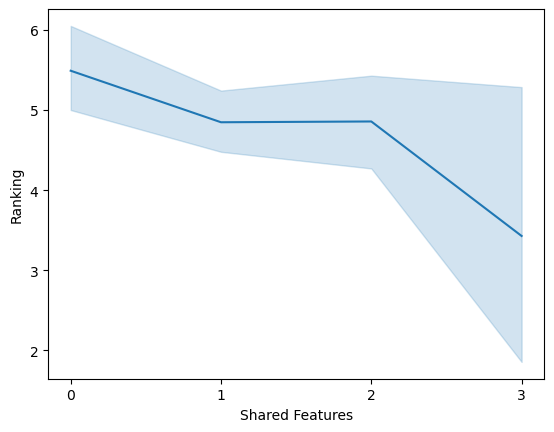

In [18]:

g = sns.lineplot(
    data=data, 
    y='output', x='shared_features')
g.set_ylabel('Ranking')
g.set_xlabel('Shared Features')
g.set_xticks([0, 1, 2, 3]);

In [ ]:

data.to_csv('experiments/sortablerank/data.csv', index=False)